# Data Augmentation 

In this notebook, I explore data augmentation using the tensorflow patch_camelyon dataset, which is comprised of histopathic images of lymph nodes and binary labels indicating the presence of metatstatic (cancerous) tissue.



Import libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import layers


Download our dataset (~8GB):

In [2]:
df, metadata = tfds.load(
    'patch_camelyon',
    data_dir= 'D:\\tensorflow_datasets\\patch_camelyon' ,
    with_info=True,
    as_supervised=True,
)

train_data = df['train']
valid_data = df['validation']
test_data = df['test']

train_data

<PrefetchDataset shapes: ((96, 96, 3), ()), types: (tf.uint8, tf.int64)>

There are two classes:
0 represents no metastatic tissue and 1 indicates that the image does contain metastatic tissue

In [3]:
num_classes=metadata.features['label'].num_classes
class_names = metadata.features['label'].names
print(class_names)

['0', '1']


Let's display an example image from the dataset to see what we are working with:

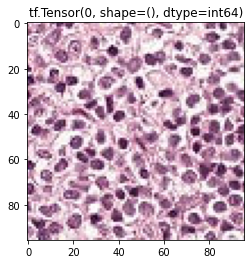

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_data))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


All images in this dataset are 96x96 RGB, so we don't have to do any resizing or reshaping. However, we will want to rescale our images from 0-255 to 0-1 and convert to float32 for augmentation functions

In [5]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)
    return image, label


Now we can experiment with data augmentation. I don't want to change the colors too much because there should be relatively standard practice for how the histopathic images should look

Tuning brightness variation - too light or dark won't give the model anything to actually learn from, I've found that max delta around .25 seems to look good 

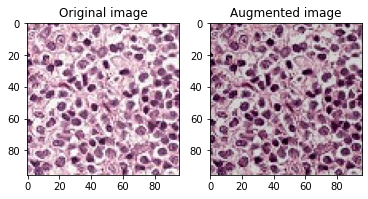

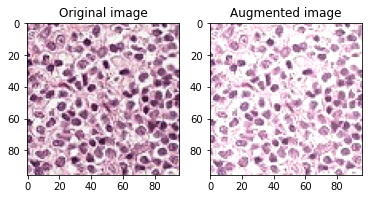

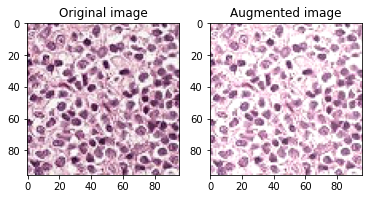

In [6]:
for i in range(3):
    seed = (i, 0)  # tuple of size (2,)
    stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.25, seed=seed)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(stateless_random_brightness)
    


We can also lower/raise the contrast some:

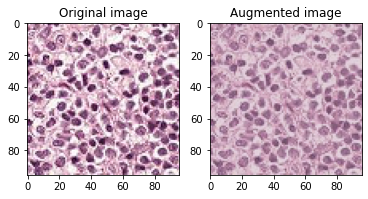

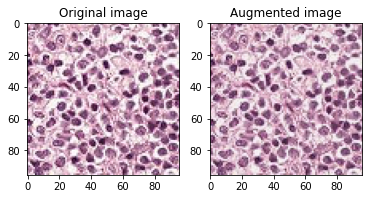

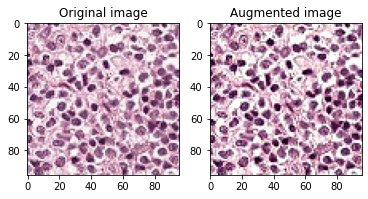

In [7]:
for i in range(3):
    seed = (i+5, 0)  # tuple of size (2,)
    stateless_random_contrast = tf.image.stateless_random_contrast(image, lower=0.5, upper=1.5, seed=seed)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(stateless_random_contrast)

And we can also reduce image quality: 

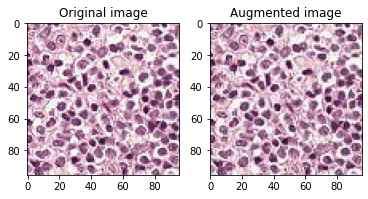

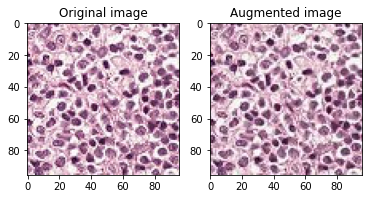

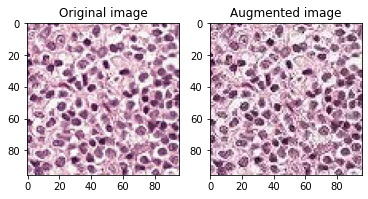

In [8]:
for i in range(3):
    seed = (i+6, 0)  # tuple of size (2,)
    stateless_random_jpeg_quality = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100, seed=seed)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(stateless_random_jpeg_quality)

Lastly, we can also rotate the images:

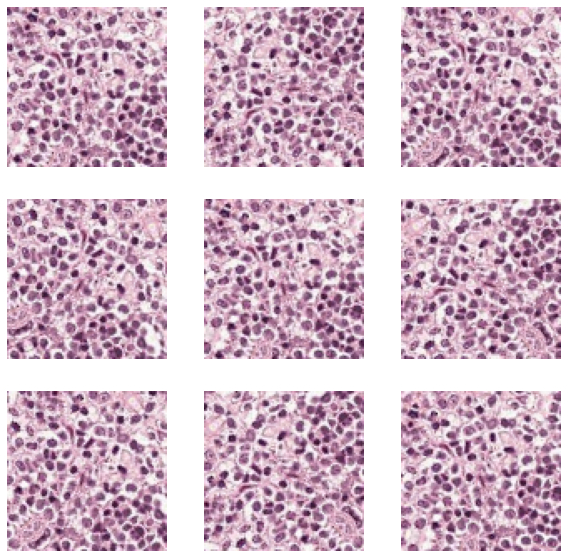

In [9]:
randrotation = layers.RandomRotation(0.2)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = randrotation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image)
    plt.axis("off")


Make our augmentation method. I've added a few more functions within it - flip up/down and left/right. I should also probably add shifts to it

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
randrotation = layers.RandomRotation(0.2)

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

def Augment(image_label,seed):
    image, label=image_label
    
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]

    image = tf.image.stateless_random_brightness(image, max_delta=0.25, seed=seed)
    image = tf.image.stateless_random_contrast(image, lower=0.5, upper=1.5, seed=seed)
    image = tf.image.stateless_random_flip_left_right(image, seed=seed)
    image = tf.image.stateless_random_flip_up_down(image, seed=seed)
    image = tf.image.stateless_random_saturation(image, lower=0.75, upper=1.0,seed=seed)
    #image =  tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=75, max_jpeg_quality=100, seed=seed)
    image = randrotation(image)
    
    image = tf.clip_by_value(image, 0, 1)


    return image, label


The following code was borrowed from tensorflow's website to ensure the seed changes, otherwise all images will have the same augmentation done on them

In [11]:
#counter = tf.data.experimental.Counter()
#train_ds = tf.data.Dataset.zip((train_data, (counter, counter)))

# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
    seed = rng.make_seeds(2)[0]
    image, label = Augment((x, y), seed)
    return image, label

Now we can map the augmentation to our datasets:

In [12]:
train_data = train_data.map(preprocess)
valid_data = valid_data.map(preprocess)
test_data = test_data.map(preprocess)

#Shuffling the train_data
buffer_size = 1000
train_data = train_data.shuffle(buffer_size)

#Batching and prefetching
batch_size = 12
train_data = train_data.batch(batch_size).prefetch(1)
valid_data = valid_data.batch(batch_size).prefetch(1)
test_data = test_data.batch(batch_size).prefetch(1)

#separate images and labels
train_images, train_labels = next(iter(train_data))
valid_images, valid_labels = next(iter(valid_data))
test_images, test_labels  = next(iter(test_data))


train_ds = (
    train_data
    .map(f, num_parallel_calls=AUTOTUNE)
)

And then we set up our model. I used the model from https://medium.com/analytics-vidhya/deep-learning-tutorial-patch-camelyon-data-set-d0da9034550e to start, but will also be tuning it.

In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = tf.keras.Sequential([
                    Conv2D(256, 3,padding='same', kernel_initializer='he_uniform', activation='relu', input_shape = [96, 96, 3]),
                    MaxPooling2D(2),
                    Conv2D(256, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(512, 3,padding='same',kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(512, 3,padding='same',kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(1024, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Conv2D(1024, 3,padding='same', kernel_initializer='he_uniform',activation='relu',),
                    MaxPooling2D(2),
                    Flatten(),
                    Dense(1028,kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(512,kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
                    Dense(1, activation = 'sigmoid'),
                    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 512)       2

Compile model:

In [14]:
# set learning rate to 0.001, use binary cross entropy loss since our labels are binary
from tensorflow.keras import optimizers

learning_rate = 1e-5
model.compile(optimizer=optimizers.Adam(learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Train model:

In [15]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=valid_data,
  epochs=epochs,
  verbose=2
)


Epoch 1/12
21846/21846 - 1701s - loss: 0.4588 - accuracy: 0.7874 - val_loss: 0.5833 - val_accuracy: 0.7447
Epoch 2/12
21846/21846 - 1695s - loss: 0.3674 - accuracy: 0.8371 - val_loss: 0.4545 - val_accuracy: 0.8067
Epoch 3/12
21846/21846 - 1689s - loss: 0.3149 - accuracy: 0.8646 - val_loss: 0.7710 - val_accuracy: 0.7182
Epoch 4/12
21846/21846 - 1690s - loss: 0.2773 - accuracy: 0.8842 - val_loss: 0.7441 - val_accuracy: 0.7354
Epoch 5/12
21846/21846 - 1690s - loss: 0.2525 - accuracy: 0.8967 - val_loss: 0.4366 - val_accuracy: 0.8102
Epoch 6/12
21846/21846 - 1690s - loss: 0.2342 - accuracy: 0.9054 - val_loss: 0.9063 - val_accuracy: 0.7108
Epoch 7/12
21846/21846 - 1690s - loss: 0.2192 - accuracy: 0.9125 - val_loss: 0.5448 - val_accuracy: 0.7888
Epoch 8/12
21846/21846 - 1690s - loss: 0.2064 - accuracy: 0.9182 - val_loss: 0.5667 - val_accuracy: 0.7763
Epoch 9/12
21846/21846 - 1690s - loss: 0.1950 - accuracy: 0.9234 - val_loss: 0.5410 - val_accuracy: 0.7826
Epoch 10/12
21846/21846 - 1690s - los

In [18]:
loss, acc = model.evaluate(test_data)
print("Accuracy", acc)


2731/2731 [==============================] - 61s 22ms/step - loss: 0.7202 - accuracy: 0.7673
Accuracy 0.76727294921875


As we can see, the data augmentation outperforms the baseline model by 10%, and also outperforms the accuracy that was achieved after 100 epochs from the page I got the model layers from in only 12 epochs (though each epoch does take longer). 